<a href="https://colab.research.google.com/github/ElaYJ/Study_Deep_Learning/blob/main/Lecture/13_transfer_learning_with_hub_refer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TensorFlow Hub에서 전이 학습 이용

<table class="tfo-notebook-buttons" align="left">
  <td><a target="_blank" href="https://www.tensorflow.org/tutorials/images/transfer_learning_with_hub"><img src="https://www.tensorflow.org/images/tf_logo_32px.png">TensorFlow.org에서 보기</a></td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ko/tutorials/images/transfer_learning_with_hub.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Google Colab에서 실행</a></td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ko/tutorials/images/transfer_learning_with_hub.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">GitHub에서 보기</a></td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ko/tutorials/images/transfer_learning_with_hub.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">노트북 다운로드</a></td>
  <td><a href="https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"><img src="https://www.tensorflow.org/images/hub_logo_32px.png">TF 허브 모델 보기</a></td>
</table>

[TensorFlow Hub](http://tensorflow.org/hub)는 사전에 훈련된 TensorFlow 모델들의 리포지토리입니다.

이 튜토리얼에서는 다음을 수행하는 방법을 보여줍니다.

1. `tf.keras`와 함께 TensorFlow Hub의 모델을 사용합니다.
2. TensorFlow Hub의 이미지 분류 모델을 사용합니다.
3. 자신의 이미지 클래스에 대한 모델을 미세 조정하기 위해 간단한 전이 학습을 수행합니다.

## 설치하기

In [1]:
import numpy as np
import time

import PIL.Image as Image
import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

import datetime

%load_ext tensorboard

## ImageNet 분류자

우선, 사전 훈련된 분류기 모델을 사용하여 이미지를 얻고 이미지가 무엇인지 예측하겠습니다. 훈련이 필요하지 않습니다!

### 분류자 다운로드하기

[TensorFlow Hub](https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2)에서 <a href="https://arxiv.org/abs/1801.04381" class="external">MobileNetV2</a> 사전 훈련된 모델을 선택하고 [`hub.KerasLayer`](https://www.tensorflow.org/hub/api_docs/python/hub/KerasLayer)를 사용하여 Keras 레이어로 래핑합니다. 아래 드롭다운에 제공된 예제를 포함하여 TensorFlow Hub의 모든 <a href="https://tfhub.dev/s?q=tf2&amp;module-type=image-classification/" class="external">호환 이미지 분류자 모델</a>이 여기에서 작동합니다.

In [2]:
classifier_url ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2" #@param {type:"string"}

In [3]:
IMAGE_SHAPE = (224, 224)

classifier = tf.keras.Sequential([
    hub.KerasLayer(classifier_url, input_shape=IMAGE_SHAPE+(3,))
])

In [4]:
classifier.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1001)              3540265   
                                                                 
Total params: 3540265 (13.51 MB)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 3540265 (13.51 MB)
_________________________________________________________________


### 단일 이미지에서 실행하기

모델을 시도하기 위한 단일 이미지를 다운로드합니다.

61306/61306 [==============================] - 0s 0us/step


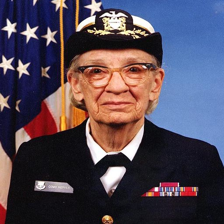

In [5]:
import numpy as np
import PIL.Image as Image

grace_hopper = tf.keras.utils.get_file('image.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper = Image.open(grace_hopper).resize(IMAGE_SHAPE)
grace_hopper

In [6]:
grace_hopper = np.array(grace_hopper)/255.0
grace_hopper.shape

(224, 224, 3)

배치 차원을 추가하고 이미지를 모델로 전달합니다.

In [7]:
result = classifier.predict(grace_hopper[np.newaxis, ...])
result.shape

1/1 [==============================] - 4s 4s/step


(1, 1001)

그 결과는 이미지에 대한 각 클래스의 확률을 계산하는 로짓의 1001 요소 벡터입니다.

그래서 최상위 클래스 ID는 argmax로 확인할 수 있습니다:

In [8]:
predicted_class = tf.math.argmax(result[0], axis=-1)
predicted_class

<tf.Tensor: shape=(), dtype=int64, numpy=653>

### 예측 디코딩하기

예측 클래스 ID를 취하고 `ImageNet` 레이블을 가져와서 예측을 디코딩합니다.

In [9]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

10484/10484 [==============================] - 0s 0us/step


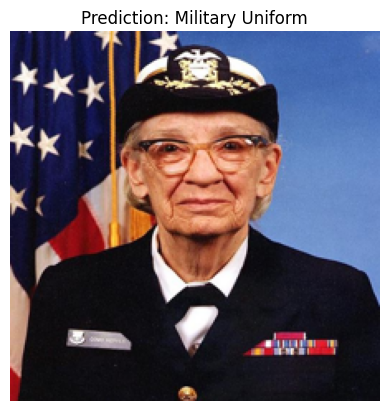

In [10]:
plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name.title())

## 간단한 전이 학습

그러나 원본 ImageNet 데이터세트(사전 훈련된 모델이 훈련된 데이터세트)에 포함되지 않은 클래스가 있는 자체 데이터세트를 사용하여 사용자 지정 분류기를 생성하려는 경우에는 어떻게 될까요?

이를 위해 다음을 수행할 수 있습니다.

1. TensorFlow Hub에서 사전 훈련된 모델을 선택합니다. 및
2. 사용자 정의 데이터세트의 클래스를 인식하도록 맨 위(마지막) 레이어를 다시 훈련시킵니다.

### 데이터세트

이 예제를 위해 TensorFlow의 꽃 데이터세트를 사용합니다.

In [11]:
import pathlib

data_file = tf.keras.utils.get_file(
  'flower_photos.tgz',
  'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
  cache_dir='.',
   extract=True)

data_root = pathlib.Path(data_file).with_suffix('')

228813984/228813984 [==============================] - 1s 0us/step


image_dataset_from_directory를 사용하여 디스크 이미지를 사용하는 식으로 이 데이터를 모델에 로드하겠습니다.

In [12]:
batch_size = 32
img_height = 224
img_width = 224

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  str(data_root),
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  str(data_root),
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


꽃 데이터세트에는 다섯 개의 클래스가 있습니다.

In [13]:
class_names = np.array(train_ds.class_names)
print(class_names)

['daisy' 'dandelion' 'roses' 'sunflowers' 'tulips']


이미지 모델에 대한 TensorFlow Hub의 규칙은 `[0, 1]` 범위의 부동 입력을 예상하는 것입니다. 이를 위해 `Rescaling` 레이어를 사용합니다.

참고: 모델 내부에 `Rescaling` 레이어를 포함할 수도 있습니다. 절충점에 대한 논의는 이 [가이드](https://www.tensorflow.org/guide/keras/preprocessing_layers)를 참조하세요.

In [14]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.

버퍼링된 프리페치를 사용하여 I/O를 차단하지 않고 디스크에서 데이터를 생성할 수 있도록 하겠습니다. 데이터를 로드할 때 다음 두 가지 중요한 메서드를 사용해야 합니다.

이것들은 데이터를 로드할 때 사용해야 하는 가장 중요한 `tf.data` 메서드 중 일부입니다. 관심 있는 독자는 [tf.data API로 성능 향상](https://www.tensorflow.org/guide/data_performance#prefetching) 가이드에서 디스크에 데이터를 캐시하는 방법과 기타 기술에 대해 자세히 알아볼 수 있습니다.

In [15]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [16]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


### 이미지 배치에 대한 분류기를 실행해보자

이제 이미지 배치에 대한 분류기를 실행해봅시다.

In [17]:
result_batch = classifier.predict(image_batch)

1/1 [==============================] - 1s 1s/step


In [18]:
predicted_class_names = imagenet_labels[tf.math.argmax(result_batch, axis=-1)]
predicted_class_names

array(['doormat', 'coral reef', 'damselfly', 'daisy', 'daisy',
       'greenhouse', 'porcupine', 'groom', 'greenhouse', 'quill', 'corn',
       'picket fence', 'daisy', 'conch', 'cardoon', 'vase', 'daisy',
       'pedestal', 'daisy', 'broom', 'cardoon', 'pinwheel', 'buckeye',
       'military uniform', 'groom', 'Bedlington terrier', 'worm fence',
       'cauliflower', 'hummingbird', 'daisy', 'daisy', 'daisy'],
      dtype='<U30')

얼마나 많은 예측들이 이미지에 맞는지 검토해봅시다:

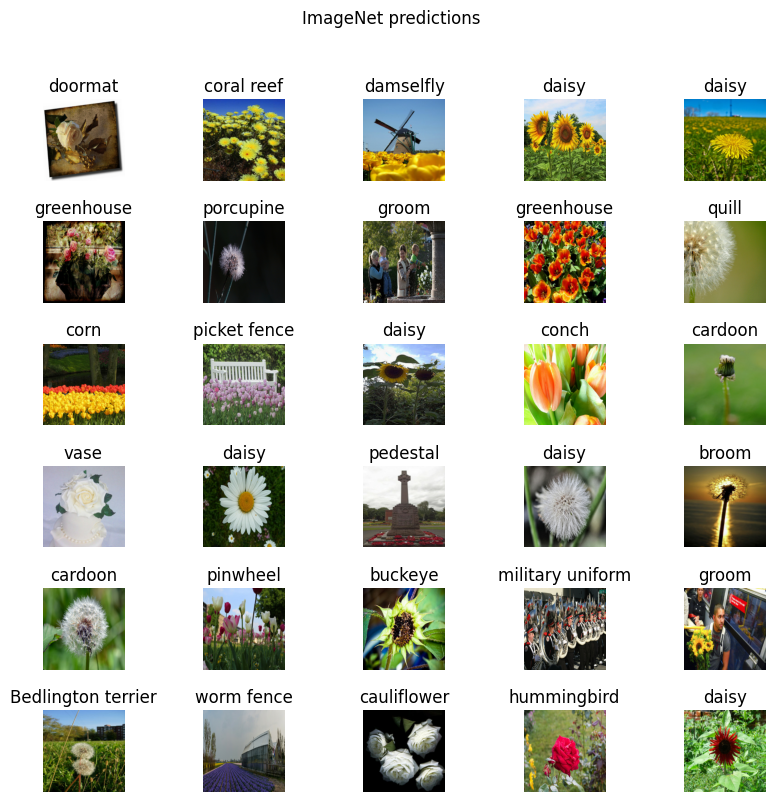

In [19]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')
_ = plt.suptitle("ImageNet predictions")

이미지 속성을 가진 `LICENSE.txt` 파일을 보세요.

결과가 완벽과는 거리가 멀지만, 모델이 ("daisy"를 제외한) 모든 것을 대비해서 학습된 클래스가 아니라는 것을 고려하면 합리적입니다.

### 헤드리스 모델을 다운로드하세요

텐서플로 허브는 맨 위 분류층이 없어도 모델을 분배 시킬 수 있습니다. 이는 전이 학습을 쉽게 할 수 있게 만들었습니다.

<a href="https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4" class="external">TensorFlow Hub</a>에서 <a href="https://arxiv.org/abs/1801.04381" class="external">MobileNetV2</a> 사전 훈련된 모델을 선택합니다. 드롭다운 메뉴의 예제를 포함하여 TensorFlow Hub의 모든 <a href="https://tfhub.dev/s?module-type=image-feature-vector&amp;q=tf2" class="external"> 호환 이미지 특성 벡터 모델</a>이 여기에서 작동합니다.

In [20]:
mobilenet_v2 = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
inception_v3 = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"

feature_extractor_model = mobilenet_v2 #@param ["mobilenet_v2", "inception_v3"] {type:"raw"}

선행 훈련된 모델을 [`hub.KerasLayer`](https://www.tensorflow.org/hub/api_docs/python/hub/KerasLayer)를 사용하고 Keras 레이어로 래핑하여 특성 추출기를 만듭니다. `trainable=False` 인수를 사용하여 변수를 고정하면 훈련하는 동안 새 분류자 레이어만 수정합니다.

In [21]:
feature_extractor_layer = hub.KerasLayer(
    feature_extractor_model,
    input_shape=(224, 224, 3),
    trainable=False)

이 것은 각각의 이미지마다 길이가 1280인 벡터가 반환됩니다:

In [22]:
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

(32, 1280)


### 분류 head를 붙이세요.

이제 `tf.keras.Sequential` 모델에 있는 허브 계층을 포장하고, 새로운 분류 계층을 추가하세요.

In [23]:
num_classes = len(class_names)

model = tf.keras.Sequential([
  feature_extractor_layer,
  tf.keras.layers.Dense(num_classes)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 5)                 6405      
                                                                 
Total params: 2264389 (8.64 MB)
Trainable params: 6405 (25.02 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [24]:
predictions = model(image_batch)

In [25]:
predictions.shape

TensorShape([32, 5])

### 모델을 학습시키세요

`Model.compile`을 사용하여 훈련 프로세스를 구성하고 `tf.keras.callbacks.TensorBoard` 콜백을 추가하여 로그를 생성하고 저장합니다.

In [26]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1) # Enable histogram computation for every epoch.

이제 모델을 학습시키기 위해 `.fit`방법을 사용하세요.

이 예제를 짧게 유지하기 위해 단 10개의 epoch 동안 훈련합니다. 나중에 TensorBoard에서 훈련 진행 상황을 시각화하려면 [TensorBoard 콜백](https://www.tensorflow.org/tensorboard/get_started#using_tensorboard_with_keras_modelfit)을 생성하고 로그를 저장합니다.

In [27]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
image_data = image_generator.flow_from_directory(str(data_root), target_size=IMAGE_SHAPE)

Found 3670 images belonging to 5 classes.


In [28]:
for image_batch, label_batch in image_data:
    print("Image batch shape:", image_batch.shape)
    print("Label batch shape:", label_batch.shape)
    break

Image batch shape: (32, 224, 224, 3)
Label batch shape: (32, 5)


In [34]:
len(image_data.labels)

3670

In [35]:
image_data.samples

3670

In [40]:
class CollectBatchStats(tf.keras.callbacks.Callback):
    def __init__(self) -> None:
       super().__init__()
       self.batch_losses = []
       self.batch_acc = []

    def on_train_batch_end(self, batch, logs=None):
        self.batch_losses.append(logs['loss'])
        self.batch_acc.append(logs['acc'])
        self.model.reset_metrics()

In [42]:
steps_per_epoch = np.ceil(2936/32)

batch_stats_callback = CollectBatchStats()

history = model.fit(train_ds, epochs=3,
                              steps_per_epoch=steps_per_epoch,
                              callbacks = [batch_stats_callback])

Epoch 1/2
92/92 [==============================] - 4s 39ms/step - loss: 0.0000e+00 - acc: 0.0000e+00
Epoch 2/2
92/92 [==============================] - 4s 39ms/step - loss: 0.0000e+00 - acc: 0.0000e+00


TensorBoard를 시작하여 각 epoch에 따라 측정 항목이 어떻게 변경되는지 확인하고 다른 스칼라 값을 추적합니다.

In [ ]:
# %tensorboard --logdir logs/fit

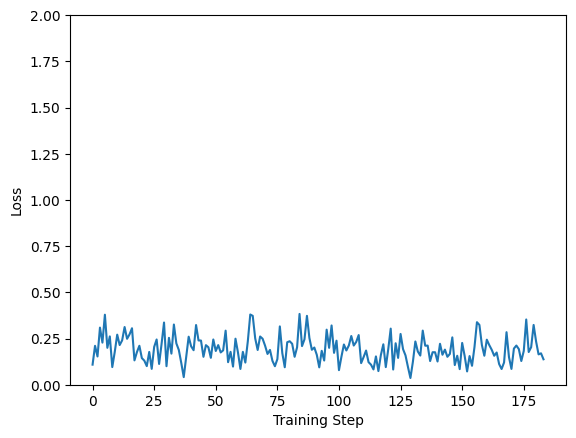

In [43]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Step")
plt.ylim([0,2])
plt.plot(batch_stats_callback.batch_losses)
plt.show()

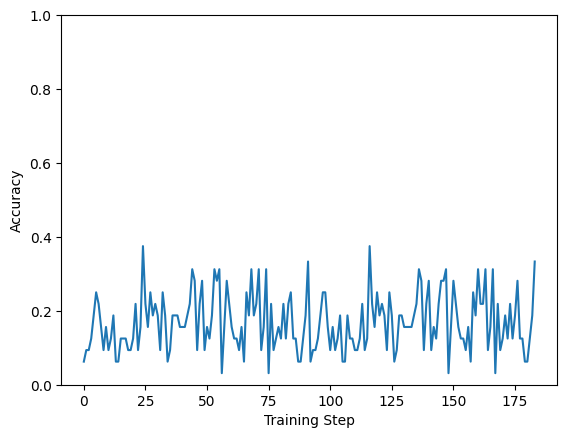

In [44]:
plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Training Step")
plt.ylim([0,1])
plt.plot(batch_stats_callback.batch_acc)
plt.show()

<!-- <img class="tfo-display-only-on-site" src="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/images/images/tensorboard_transfer_learning_with_hub.png?raw=1"/> -->

### 예측을 확인하세요

이 전의 계획을 다시하기 위해서, 클래스 이름들의 정렬된 리스트를 첫번째로 얻으세요:

In [45]:
class_names = sorted(image_data.class_indices.items(), key=lambda pair:pair[1])
class_names = np.array([key.title() for key, value in class_names])
class_names

array(['Daisy', 'Dandelion', 'Roses', 'Sunflowers', 'Tulips'],
      dtype='<U10')

결과를 계획하세요

In [46]:
predicted_batch = model.predict(val_ds)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]

23/23 [==============================] - 3s 107ms/step


In [52]:
label_id = np.argmax(label_batch, axis=-1)
label_id

array([2, 3, 4, 2, 4, 4, 2, 2, 2, 2, 4, 3, 3, 4, 4, 2, 2, 3, 2, 2, 1, 4,
       1, 0, 2, 0, 1, 0, 1, 1, 0, 4])

In [54]:
# 검증 데이터셋에서 레이블 데이터만 분리하여 리스트에 저장
val_labels = []
for _, labels in val_ds:
    val_labels.extend(labels.numpy())
print(val_labels)

[0, 4, 3, 0, 3, 4, 1, 2, 4, 0, 0, 0, 4, 4, 4, 3, 3, 0, 0, 3, 1, 4, 4, 2, 3, 3, 1, 2, 1, 2, 4, 1, 1, 0, 2, 2, 3, 1, 3, 4, 2, 3, 4, 4, 3, 4, 4, 3, 4, 1, 4, 1, 4, 1, 1, 1, 1, 2, 0, 2, 2, 1, 1, 1, 3, 1, 0, 3, 4, 1, 0, 2, 3, 0, 3, 1, 0, 0, 3, 0, 4, 2, 3, 1, 4, 3, 1, 4, 2, 1, 1, 0, 1, 2, 4, 2, 0, 2, 4, 3, 2, 1, 1, 2, 0, 0, 1, 4, 3, 0, 4, 2, 0, 0, 0, 1, 0, 4, 4, 4, 0, 4, 4, 3, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 3, 0, 3, 4, 2, 3, 0, 3, 2, 2, 3, 2, 4, 3, 4, 0, 4, 2, 2, 0, 2, 1, 0, 3, 2, 3, 0, 2, 4, 3, 0, 2, 3, 3, 4, 0, 1, 2, 3, 0, 4, 3, 3, 1, 3, 2, 3, 1, 1, 2, 1, 4, 0, 1, 3, 3, 2, 2, 4, 1, 3, 1, 4, 1, 1, 0, 1, 4, 3, 1, 1, 3, 3, 4, 1, 1, 0, 4, 1, 1, 1, 1, 3, 4, 3, 0, 2, 2, 1, 4, 1, 1, 3, 1, 0, 0, 4, 4, 0, 1, 4, 3, 4, 4, 0, 2, 3, 3, 3, 4, 0, 2, 4, 1, 1, 0, 1, 0, 3, 3, 4, 2, 0, 3, 4, 4, 1, 0, 2, 4, 0, 2, 4, 4, 3, 1, 4, 2, 3, 3, 3, 3, 3, 1, 4, 4, 3, 2, 2, 3, 3, 0, 3, 1, 1, 4, 4, 1, 4, 4, 3, 4, 0, 1, 1, 2, 0, 4, 1, 0, 3, 1, 1, 4, 3, 4, 1, 0, 4, 2, 1, 4, 2, 0, 4, 0, 3, 3, 1, 0, 4, 4, 4, 2, 3, 1, 2, 2, 3, 

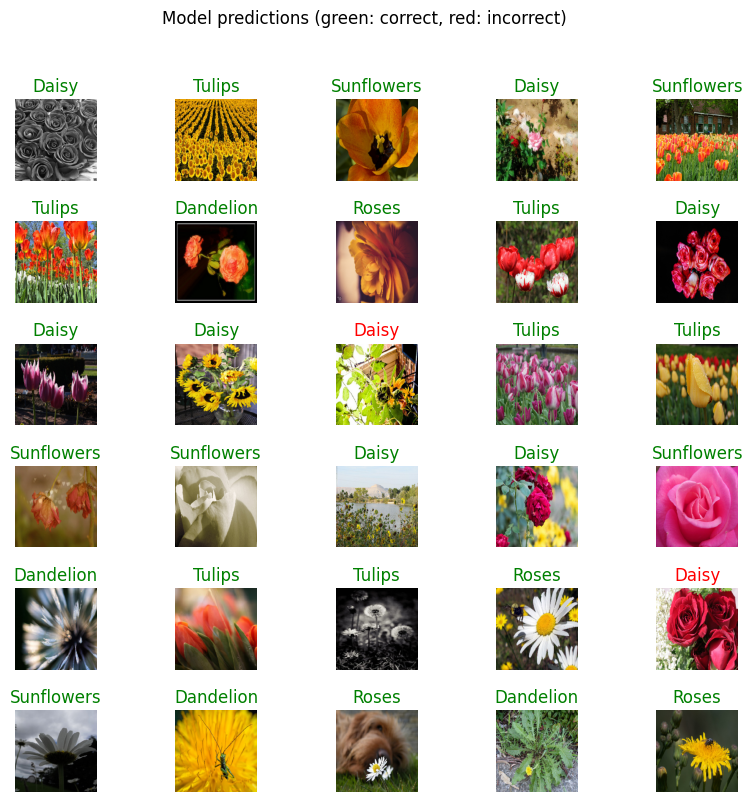

In [55]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)

for n in range(30):
    plt.subplot(6,5,n+1)
    plt.imshow(image_batch[n])
    color = "green" if predicted_id[n] == val_labels[n] else "red"
    plt.title(predicted_label_batch[n].title(), color=color)
    plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")

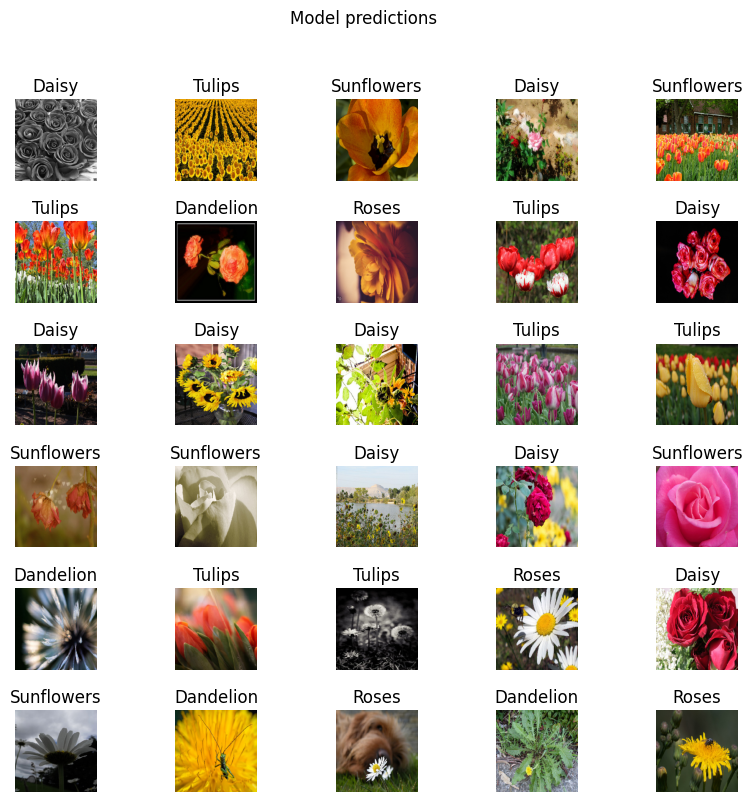

In [48]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)

for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_label_batch[n].title())
  plt.axis('off')
_ = plt.suptitle("Model predictions")

## 당신의 모델을 내보내세요

당신은 모델을 학습시켜왔기 때문에, 저장된 모델을 내보내세요:

In [49]:
t = time.time()

export_path = "./tmp/saved_models/{}".format(int(t))
model.save(export_path, save_format='tf')

export_path

'/tmp/saved_models/1713254234'

이제 우리는 그것을 새롭게 로딩 할 수 있고, 이는 같은 결과를 줄 것입니다:

In [50]:
reloaded = tf.keras.models.load_model(export_path)

In [56]:
result_batch = model.predict(val_ds)
reloaded_result_batch = reloaded.predict(val_ds)

23/23 [==============================] - 1s 34ms/step


In [57]:
abs(reloaded_result_batch - result_batch).max()

0.0

In [58]:
reloaded_predicted_id = np.argmax(reloaded_result_batch, axis=-1)
reloaded_predicted_label_batch = class_names[reloaded_predicted_id]

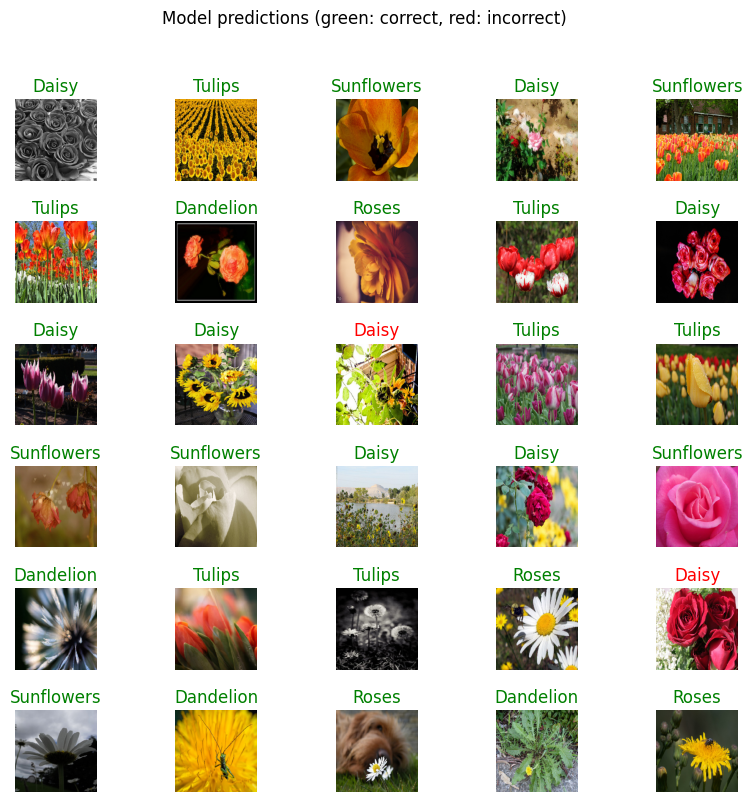

In [59]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)

for n in range(30):
    plt.subplot(6,5,n+1)
    plt.imshow(image_batch[n])
    color = "green" if reloaded_predicted_id[n] == val_labels[n] else "red"
    plt.title(predicted_label_batch[n].title(), color=color)
    plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")

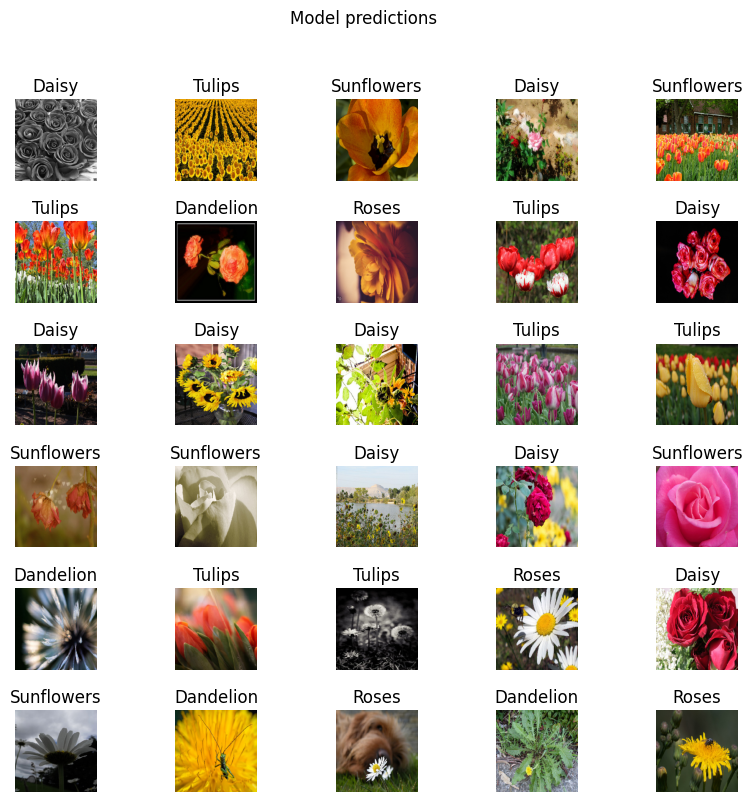

In [60]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(reloaded_predicted_label_batch[n].title())
  plt.axis('off')
_ = plt.suptitle("Model predictions")

## 자세히 알아보기

저장된 모델을 사용하여 추론을 위해 로드하거나 [TensorFlow Lite](https://www.tensorflow.org/lite/models/convert/) 모델(장치 내 머신 러닝용) 또는 [TensorFlow.js](https://www.tensorflow.org/js/tutorials#convert_pretrained_models_to_tensorflowjs) 모델(JavaScript의 머신 러닝용)로 변환할 수 있습니다.

이미지, 텍스트, 오디오 및 비디오 작업에 TensorFlow Hub의 사전 훈련된 모델을 사용하는 방법을 알아보려면 [더 많은 튜토리얼](https://www.tensorflow.org/hub/tutorials)을 살펴보세요.